Importing

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench import (
    MultiprocessingEvaluator,
    save_results,
    load_results,
    Policy)
from ema_workbench.analysis import parcoords

from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(6)

----
# Re-evaluate candidate solutions under uncertainty
From notebook 'MOEA_analysis.ipynb' a large number of candidate solutions (policies) have now been given. The Delta Commission gives a hard constraint on *Annual Expected Deaths*. No solution with more than 0 deaths is acceptable to them. From this, the following 65 policies have emerged. 


In [4]:
# load policies
policies = pd.read_csv('data/policies.csv')

In [5]:
# drop first column 
policies = policies.drop(policies.columns[0], axis=1) 

In [6]:
# create empty list to store policies
policies_to_evaluate = [] 

# iterate over policies and add to list
for i, policy in policies.iterrows():
    policy_dict = policy.to_dict() 
    unique_name = f"policy_{i}"  
    policies_to_evaluate.append(Policy(name=unique_name, **policy_dict)) 



We can re-evaluate these over the different deeply uncertain factors to assess their robustness against uncertainties. For this robustness evaluation, we are going to examine the scenarios for each solution. In this case, 1000 random scenarios have been chosen. 

In [5]:
# # number of scenarios
# n_scenarios = 1000 

# # Perform experiments
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=n_scenarios,
#                                             policies=policies_to_evaluate)

100%|██████████████████████████████████| 79000/79000 [6:38:29<00:00,  3.30it/s]


In [25]:
# save_results((results), 'data/robustness_results.tar.gz')

To check the steps done in this robustness analysis, you can import the results below 

In [140]:
# load results
results = load_results('data/robustness_results.tar.gz')

### Evaluating Policy Robustness

We can now assess the robustness of each policy option using the scenario results. The robustness of a policy option can be measured by its performance on an outcome indicator over 1,000 different scenarios. This allows us to determine how stable a policy is with respect to each outcome indicator and examine the trade-off between robustness and performance.

Robustness can be quantified using different metrics. Here, we use the signal-to-noise ratio (SNR). In the context of evaluating the robustness of policy options using the signal-to-noise ratio (SNR), the approach to calculating the SNR differs depending on whether the goal is to maximize or minimize the outcome indicator. When the goal is to minimize an outcome indicator, the desired result is a low mean and low variability (standard deviation). Here, a low mean indicates good performance in terms of minimization, and a low standard deviation indicates that this performance is consistently low with little variability. By multiplying the mean by the standard deviation, we capture both aspects: a lower product indicates a better outcome since both the mean and variability contribute to the result. If either the mean or the standard deviation is high, the product will be high, indicating poorer performance.

To calculate the signal-to-noise ratio for each policy, we follow these steps:

In [141]:
# Calculating the signal-to-noise ratio
def s_to_n(data, direction): 
    """
    Calculate the signal-to-noise ratio (SNR).
    
    Parameters:
    data (np.ndarray): An array of data values for which the SNR is to be calculated.
    direction (str): A string indicating the direction of optimization ('maximize' or 'minimize'). 
                     This parameter is included for completeness but is not used in the current implementation.
    
    Returns:
    float: The signal-to-noise ratio, calculated as the product of the mean and the standard deviation of the data.
    """
    mean = np.mean(data) 
    std = np.std(data)
    return mean * std

### Visualisation

To facilitate analysis and visualisation of the results, all calculated SNR values are converted into a data frame. This structured format allows easy comparison and interpretation of the robustness of different policy options for different outcome indicators.



In [142]:
# unpack results
experiments, outcomes = results
 
# create empty dictionary to store scores
overall_scores = {} 

# get signal-to-noise ratio for each policy
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']== policy # select policy
    
    for outcome in dike_model.outcomes: 
        value  = outcomes[outcome.name][logical] # select outcome
        sn_ratio = s_to_n(value, outcome.kind) # calculate signal-to-noise ratio
        scores[outcome.name] = sn_ratio # store signal-to-noise ratio in dictionary
    overall_scores[policy] = scores 
scores = pd.DataFrame.from_dict(overall_scores).T # convert dictionary to dataframe

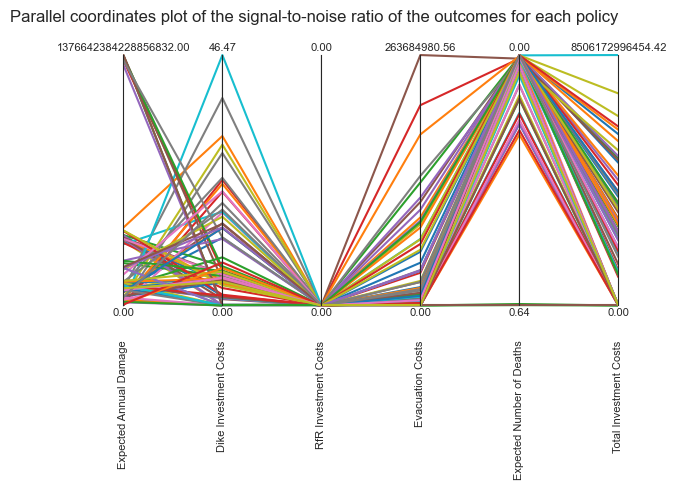

In [149]:
# Plotting the parallel coordinates plot
limits = parcoords.get_limits(scores)
limits.loc[0, ["Expected Annual Damage","Dike Investment Costs","RfR Investment Costs","Evacuation Costs","Expected Number of Deaths","Total Investment Costs"]] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=8)
paraxes.plot(scores)
paraxes.invert_axis('Expected Number of Deaths')

plt.title('Parallel coordinates plot of the signal-to-noise ratio of the outcomes for each policy', loc = 'Right')
plt.show()

Since the SNR is based on minimizing outcomes, lower values on each axis are better. Policies with lines that stay consistently lower across all axes are generally more robust, indicating lower mean values and lower variability in the outcomes. A policy that maintains low SNR scores across all outcome indicators is preferable. We look for policies where the lines are generally lower across the majority of the axes. These policies are likely to be more robust and balanced in minimizing negative outcomes.

Given the high number of policies, we will further include the most robust 25% of policies. 

In [110]:
# Apply the filtering
scores2 = scores.drop(scores['Expected Number of Deaths'].nlargest(60).index)
print("Now we got:" , len(scores2), "policies")

Now we got: 19 policies


In [138]:
policies2 = scores2.reset_index()
policies2 = policies2.iloc[:,0]
policies2 = policies2.tolist()

print(policies2)

['policy_11', 'policy_12', 'policy_13', 'policy_17', 'policy_18', 'policy_19', 'policy_20', 'policy_33', 'policy_35', 'policy_44', 'policy_48', 'policy_51', 'policy_52', 'policy_66', 'policy_7', 'policy_72', 'policy_73', 'policy_75', 'policy_8']


---
### Maximum Regret
Another way to quantify robustness are metrics based on regret. These are used to assess the performance of a decision alternative by comparing it with the best possible alternative under the same circumstances. The regret of a decision alternative is defined as the difference between the performance of the chosen option for a specific scenario and the performance of the best possible option for that same scenario. This approach allows us to assess how much worse a chosen decision performs compared to the optimal decision, providing insight into the potential cost of not choosing the best possible option. Based on the most robust policies that emerged from the SNR scores, we proceeded to test for regret.


In [113]:
# Calculate the regret
def calculate_regret(data, best):
    """
    Calculate the regret based on the best possible outcome.
    
    Parameters:
    data (np.ndarray): An array of outcome values for different policies.
    best (np.ndarray or float): The best possible outcome value(s). This can be a scalar or an array of the same shape as data.
    
    Returns:
    np.ndarray: An array of regret values, which are the absolute differences between the best possible outcome and the actual outcomes.
    """
    return np.abs(best - data)

In [114]:
# creating results dataframe using outcomes and experiments
outcomes_df = pd.DataFrame(outcomes)
experiments_df = pd.DataFrame(experiments)

results_df = experiments_df.merge(outcomes_df, left_index=True, right_index=True)

In [115]:
# creating a dataframe with resulting polcies
best_policies = results_df[results_df['policy'].isin(policies2)]

In [116]:
# we need filtered new outcomes and experiments on the resulting policies
experiment_col = experiments.keys()
outcomes_col = outcomes.keys()
experiments2 = best_policies[experiment_col]
outcomes2 = best_policies[outcomes_col]
outcomes2 = {col: np.array(outcomes2[col]) for col in outcomes2.columns}

Calculating maximum regret involves arranging policies and scenarios in a DataFrame, tilting the DataFrame so that scenarios are displayed as rows and policies as columns. For each outcome, regret is calculated by finding the difference between the maximum outcome value for each scenario and the actual outcome values, taking the absolute value. This measures how much worse each policy performs compared to the best policy in each scenario. The maximum regret is then the highest regret value across all scenarios for each outcome, indicating the worst performance of each policy.

In [117]:
# calculating regret 
overall_regret = {}
max_regret = {}

for outcome in dike_model.outcomes:
    policy_column = experiments2['policy']
    
    # create a DataFrame with all the relevent information
    data = pd.DataFrame({outcome.name: outcomes2[outcome.name], 
                         "policy":experiments2['policy'],
                         "scenario":experiments2['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from pivoting
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

## Visualisation

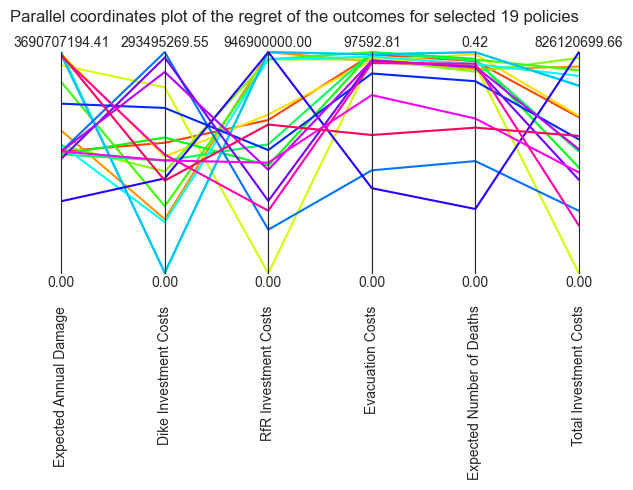

In [152]:
# Plotting the parallel coordinates plot
data = pd.DataFrame(max_regret)

# Dynamically create a color palette with the number of unique policies
num_policies = len(data)
colors = sns.color_palette("hsv", num_policies)

# Makes it easier to identify the policy associated with each line
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs', 
            'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths', 
            'Total Investment Costs']] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])

plt.title('Parallel coordinates plot of the regret of the outcomes for selected 19 policies', loc = 'Right')
plt.show()


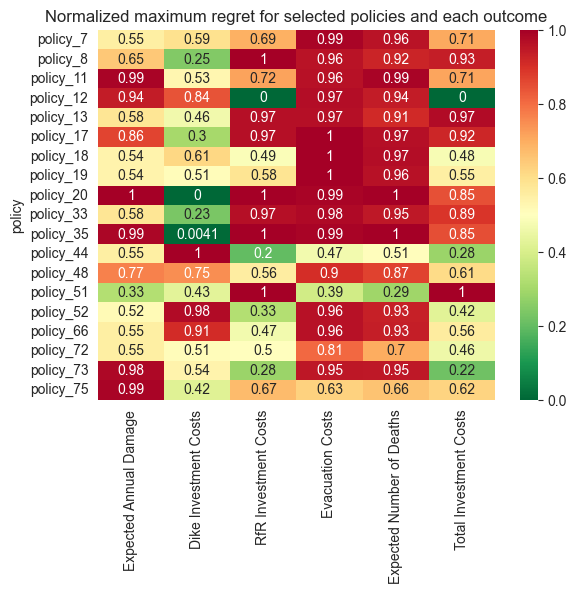

In [153]:
# Create a dataframe of the maximum regret
max_regret = pd.DataFrame(max_regret)

# Normalize the data
normalized_regret_all = max_regret/max_regret.max()

# Create the heatmap
sns.heatmap(normalized_regret_all, cmap='RdYlGn_r', annot=True)
plt.title('Normalized maximum regret for selected policies and each outcome')
plt.show()

Interpretation of the heatmap
The heatmap visualises the regret of different policies across different criteria, with the colours representing normalised regret values where 0 indicates no regret (best outcome) and 1 the highest regret (worst outcome).

- Green (0): Indicates no regret for a given criterion, meaning the policy performs as well as the best policy for that criterion.
- Dark red (1): Indicates highest regret for a given criterion, meaning the policy performs significantly worse than the best policy for that criterion.

From this heatmap, we can see several trade-offs. It is clear that policies with high regret for the Expected Number of Deaths often (but not always) correspond to lower regret for cost variables. In addition, we see that low regret for Expected Annual Damage is often accompanied by high regret in one or more of the three cost categories.

Moreover, policies with extremely low regret in the cost of dike investments often show high regret in expected annual damage and expected fatalities. It is interesting to note that a low Regret in Total Investment Cost does not necessarily correlate with an extremely high Regret in Mortality and Damage, as seen with Policy 44. However, this policy does show a high Regret in Total Investment Cost. However, this policy does show a high Regret in RfR Investment Costs.

-----
### Final Policies

Given the complexity of the heatmap, it can be difficult to interpret. Therefore, we decided to filter the policies to improve our analysis. To improve our focus on the most critical outcomes, we filtered policies based on the 20th quantile of the expected number of deaths. This outcome is of paramount importance according to the Delta Commission. By focusing on this specific criterion, we aim to provide a more focused and effective evaluation.

In [121]:
# Filter the maximum regret on the 20th percentile
quantile = max_regret['Expected Number of Deaths'].quantile(0.20)
x = (max_regret < quantile)
filtered_max_regret = max_regret[x['Expected Number of Deaths'] == True]


In [134]:
# Print the number of policies left
policy_list = []
for i in filtered_max_regret.index:
    policy_list.append(i)

# Filter the best policies
final_policies = best_policies[best_policies['policy'].isin(policy_list)]
final_policies = final_policies.drop_duplicates(subset='policy', keep='first')

# Print the number of policies left
print("This leaves us with", len(final_policies), "policies")
print(policy_list)

This leaves us with 4 policies
['policy_44', 'policy_51', 'policy_72', 'policy_75']


In [123]:
filtered_scores = scores.loc[policy_list]

In [136]:
experiments[experiments['policy'] == "policy_44"]

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
44000,109,173.567742,1.5,0.835907,293.791771,10.0,0.508254,169.705251,1.0,0.729168,...,0,0,0,0,0,0,0,0,policy_44,dikesnet
44001,28,162.883415,1.0,0.227612,303.768237,1.5,0.226091,31.950297,1.5,0.161768,...,0,0,0,0,0,0,0,1,policy_44,dikesnet
44002,73,341.499962,1.0,0.551102,187.960513,1.5,0.440181,85.663440,10.0,0.338482,...,0,0,0,0,0,0,0,2,policy_44,dikesnet
44003,12,135.396610,1.0,0.986133,217.905896,1.5,0.801750,160.399809,1.5,0.319077,...,0,0,0,0,0,0,0,3,policy_44,dikesnet
44004,18,139.375225,1.5,0.402573,174.217223,10.0,0.272431,159.781770,1.0,0.248402,...,0,0,0,0,0,0,0,4,policy_44,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,42,143.123570,1.5,0.932370,259.224600,1.0,0.629904,138.258554,10.0,0.304826,...,0,0,0,0,0,0,0,995,policy_44,dikesnet
44996,93,321.767932,1.5,0.735205,309.580574,1.5,0.842250,344.788117,1.0,0.955866,...,0,0,0,0,0,0,0,996,policy_44,dikesnet
44997,125,58.959664,1.5,0.238372,53.604955,1.5,0.492734,245.037879,1.0,0.207850,...,0,0,0,0,0,0,0,997,policy_44,dikesnet
44998,38,295.540626,1.5,0.824363,203.665593,1.0,0.402240,332.522542,1.0,0.427583,...,0,0,0,0,0,0,0,998,policy_44,dikesnet


In [128]:
# Calculate mean outcome and put into a df
mean_scores = {}
for policy in policy_list:
    scores = {}

    logical = experiments['policy']==policy

    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        mean = np.mean(value)
        scores[outcome.name] = mean
    mean_scores[policy] = scores
final_mean_scores_df = pd.DataFrame.from_dict(mean_scores).T

final_mean_scores_df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs
policy_44,2.148541e+08,9.751348e+07,759800000.0,7055.284595,0.019106,8.573205e+08
policy_51,2.195366e+08,2.649944e+08,0.0,4092.651502,0.021553,2.649985e+08
policy_72,1.496210e+08,2.411797e+08,473000000.0,1888.993534,0.015730,7.141815e+08
policy_75,2.868487e+07,2.679778e+08,309900000.0,825.328903,0.004495,5.778786e+08


### Visualization of Final Policies

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/parcoords.py:281: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


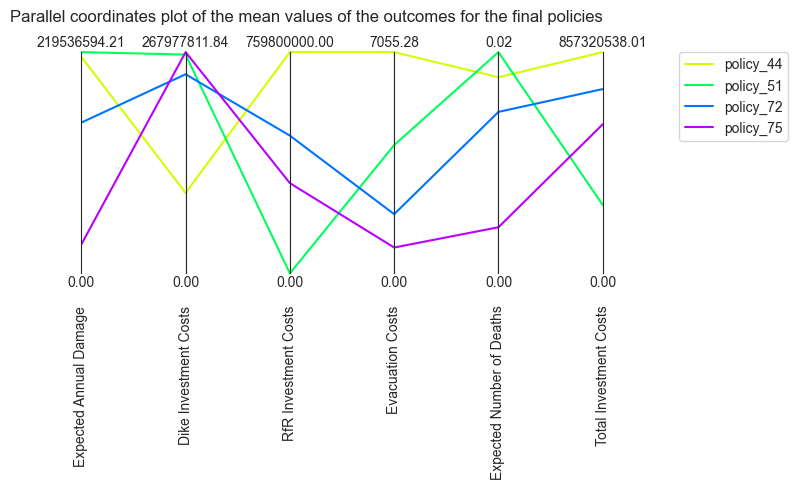

In [156]:
# Plotting the parallel coordinates plot
colors = sns.color_palette()
data = pd.DataFrame(final_mean_scores_df)

# Dynamically create a color palette with the number of unique policies
num_policies = len(data)
colors = sns.color_palette("hsv", num_policies)

# Makes it easier to identify the policy associated with each line
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs', 
            'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths', 
            'Total Investment Costs']] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])

plt.title('Parallel coordinates plot of the mean values of the outcomes for the final policies', loc = 'Right')
paraxes.legend()
plt.show()


- Policy_44 focuses heavily on Room for the River projects and moderate dike investments, resulting in high associated costs, deaths, and damages.
- Policy_51 relies heavily on increasing dikes and does not invest in Room for the River projects, resulting in substantial damage, high dike investment costs, and an extremely high number of deaths.
- Policy_72 adopts a balanced approach with moderate investments across all levers, excluding any increase in Dike 1. This results in the most moderate outcomes across all metrics.
- Policy_75 focuses on substantial dike increases and activates several Room for the River projects, coupled with a 2-day early warning system. This policy achieves the highest total costs but the lowest expected deaths and the lowest annual damage.

In [89]:
# Save the final policies to a csv file

uncertainties = ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2']
KPIs = ['Expected Number of Deaths', 'Expected Annual Damage', 'Dike Investment Costs',
         'RfR Total Costs', 'Expected Evacuation Costs']

final_policies.drop(columns=uncertainties, inplace=True)
final_polcies_df = final_policies.drop(columns = {'scenario'})
final_polcies_df.to_csv('data/final_policies.csv')